# Custom training: basics

In the previous tutorial, you covered the TensorFlow APIs for automatic differentiation—a basic building block for machine learning. In this tutorial, you will use the TensorFlow primitives introduced in the prior tutorials to do some simple machine learning.

TensorFlow also includes tf.keras—a high-level neural network API that provides useful abstractions to reduce boilerplate and makes TensorFlow easier to use without sacrificing flexibility and performance. We strongly recommend the tf.Keras API for development. However, in this short tutorial you will learn how to train a neural network from first principles to establish a strong foundation.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

## Variables

Tensors in TensorFlow are immutable stateless objects. Machine learning models, however, must have changing state: as your model trains, the same code to compute predictions should behave differently over time (hopefully with a lower loss!). To represent this state, which needs to change over the course of your computation, you can choose to rely on the fact that Python is a stateful programming language:

In [2]:
# Using Python state
x = tf.zeros([10, 10])
x += 2  # This is equivalent to x = x + 2, which does not mutate the original
        # value of x
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


TensorFlow has stateful operations built-in, and these are often easier than using low-level Python representations for your state. Use tf.Variable to represent weights in a model.

A tf.Variable object stores a value and implicitly reads from this stored value. There are operations (tf.assign_sub, tf.scatter_update, etc.) that manipulate the value stored in a TensorFlow variable.

In [3]:
v = tf.Variable(1.0)
# Use Python's `assert` as a debugging statement to test the condition
assert v.numpy() == 1.0

# Reassign the value `v`
v.assign(3.0)
assert v.numpy() == 3.0

# Use `v` in a TensorFlow `tf.square()` operation and reassign
v.assign(tf.square(v))
assert v.numpy() == 9.0


Computations using tf.Variable are automatically traced when computing gradients. For variables that represent embeddings, TensorFlow will do sparse updates by default, which are more computation and memory efficient.

A tf.Variable is also a way to show a reader of your code that a piece of state is mutable.

## Fit a linear model

Let's use the concepts you have learned so far—Tensor, Variable, and GradientTape—to build and train a simple model. This typically involves a few steps:

1. Define the model.
2. Define a loss function.
3. Obtain training data.
4. Run through the training data and use an "optimizer" to adjust the variables to fit the data.

Here, you'll create a simple linear model, f(x) = x * W + b, which has two variables: W (weights) and b (bias). You'll synthesize data such that a well trained model would have W = 3.0 and b = 2.0.

### Define the model

Let's define a simple class to encapsulate the variables and the computation:

In [4]:
class Model(object):
  def __init__(self):
    # Initialize the weights to `5.0` and the bias to `0.0`
    # In practice, these should be initialized to random values (for example, with `tf.random.normal`)
    self.W = tf.Variable(5.0)
    self.b = tf.Variable(0.0)

  def __call__(self, x):
    return self.W * x + self.b

model = Model()

assert model(3.0).numpy() == 15.0

### Define a loss function

A loss function measures how well the output of a model for a given input matches the target output. The goal is to minimize this difference during training. Let's use the standard L2 loss, also known as the least square errors:

In [5]:
def loss(predicted_y, target_y):
  return tf.reduce_mean(tf.square(predicted_y - target_y))

### Obtain training data

First, synthesize the training data by adding random Gaussian (Normal) noise to the inputs:

In [6]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
noise   = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

Before training the model, visualize the loss value by plotting the model's predictions in red and the training data in blue:

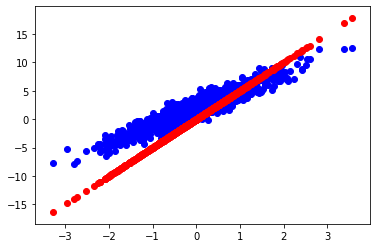

Current loss: 8.784515


In [7]:
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: %1.6f' % loss(model(inputs), outputs).numpy())

### Define a training loop

With the network and training data, train the model using gradient descent to update the weights variable (W) and the bias variable (b) to reduce the loss. There are many variants of the gradient descent scheme that are captured in tf.train.Optimizer—our recommended implementation. But in the spirit of building from first principles, here you will implement the basic math yourself with the help of tf.GradientTape for automatic differentiation and tf.assign_sub for decrementing a value (which combines tf.assign and tf.sub):

In [8]:
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
  dW, db = t.gradient(current_loss, [model.W, model.b])
  model.W.assign_sub(learning_rate * dW)
  model.b.assign_sub(learning_rate * db)

Finally, let's repeatedly run through the training data and see how W and b evolve.

Epoch  0: W=5.00 b=0.00, loss=8.78452
Epoch  1: W=4.62 b=0.40, loss=6.00398
Epoch  2: W=4.31 b=0.73, loss=4.21703
Epoch  3: W=4.06 b=0.98, loss=3.06846
Epoch  4: W=3.86 b=1.19, loss=2.33010
Epoch  5: W=3.70 b=1.35, loss=1.85537
Epoch  6: W=3.57 b=1.48, loss=1.55010
Epoch  7: W=3.46 b=1.58, loss=1.35376
Epoch  8: W=3.38 b=1.67, loss=1.22747
Epoch  9: W=3.31 b=1.73, loss=1.14622


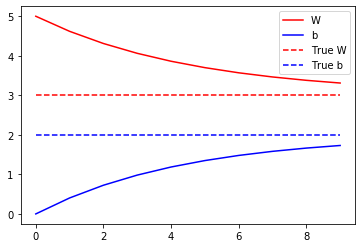

In [9]:
model = Model()

# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
  Ws.append(model.W.numpy())
  bs.append(model.b.numpy())
  current_loss = loss(model(inputs), outputs)

  train(model, inputs, outputs, learning_rate=0.1)
  print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))

# Let's plot it all
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'True W', 'True b'])
plt.show()


## Next steps

This tutorial used tf.Variable to build and train a simple linear model.

In practice, the high-level APIs—such as tf.keras—are much more convenient to build neural networks. tf.keras provides higher level building blocks (called "layers"), utilities to save and restore state, a suite of loss functions, a suite of optimization strategies, and more. Read the TensorFlow Keras guide to learn more.